In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from skimage import morphology

# Load and view data

In [2]:
class Sample:
    """ Sample from the dataset """

    def __init__(self, gtText, filePath):
        self.gtText = gtText
        self.filePath = filePath


filePath = '/kaggle/input/iam-handwriting-word-database/'
data = open(filePath + 'words_new.txt')
samples = []
bad_samples = []
bad_samples_reference = ['a01-117-05-02.png', 'r06-022-03-05.png']
for line in data:
    # ignore comment line

    if not line or line[0] == '#':
        continue

    lineSplit = line.strip().split(' ')  ## remove the space and split with ' '
    # assert len(lineSplit) >= 9
    if lineSplit[0] == 'a01-117-05-02' or lineSplit[0] == 'r06-022-03-05':
        continue
    # filename: part1-part2-part3 --> part1/part1-part2/part1-part2-part3.png
    fileNameSplit = lineSplit[0].split('-')
    fileName = filePath + 'iam_words/words/' + fileNameSplit[0] + '/' + fileNameSplit[0] + '-' + fileNameSplit[1] + '/' + \
               lineSplit[0] + '.png'

    # GT text are columns starting at 10
    # see the lines.txt and check where the GT text starts, in this case it is 10
    gtText = lineSplit[8]

    # check if image is not empty
    if not os.path.getsize(fileName):
        bad_samples.append(lineSplit[0] + '.png')
        continue

    # put sample into list
    samples.append(Sample(gtText, fileName))



##plt.figure(figsize=(15, 10))
########### figura data #############
#for i in range(6):
#    ax = plt.subplot(2, 3, i+1)
#    img_dir = samples[i].filePath
#    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
#    plt.imshow(image, cmap = 'gray')
#    plt.title(samples[i].gtText, fontsize=12)
#    plt.axis('off')

#plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [3]:
def containsNumber(value):
    for character in value:
        if character.isdigit():
            return True
    return False

# Preparing the labels for CTC Loss

In [4]:
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
max_str_len = 24 # max length of input labels
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 64 # max length of predicted labels


def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))
        
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

# model

In [5]:
input_data = Input(shape=(256,64, 1), name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
#inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 1), name='max3')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(256, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2,1), name='max4')(inner)
#inner = Dropout(0.3)(inner)


# CNN to RNN
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()
len(model.layers)

2022-07-03 02:27:11.981796: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-03 02:27:12.082880: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-03 02:27:12.083683: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-03 02:27:12.084765: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 256, 64, 1)]      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 256, 64, 32)       320       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 64, 32)       128       
_________________________________________________________________
activation (Activation)      (None, 256, 64, 32)       0         
_________________________________________________________________
max1 (MaxPooling2D)          (None, 128, 32, 32)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 128, 32, 64)       18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 32, 64)       256   

24

In [6]:
# the ctc loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [7]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

# fitting model

In [8]:
# the loss calculation occurs elsewhere, so we use a dummy lambda function for the loss
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(lr = 0.0001))


for j in range(2):
    train_size=10000
    print('iter :',j)
    for k in range(3) :
        
        import re
        train_x = []
        train_y=[]
        train=[]
        for i in range(10000):
            xx=samples[i+k*10000].gtText;
            if (bool(re.match('^[a-zA-Z0-9]*$',xx))==True) and containsNumber(xx)==False :
                train.append(xx.upper())
                img_dir = samples[i+k*10000].filePath
                image = cv2.imread(img_dir,cv2.IMREAD_GRAYSCALE)
                
                bw= cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11, 10)
                bw=cv2.resize(bw,(256,64))
                
                #end of local thresholding
                kernal = np.ones((2,1), 'uint8')
                bw = cv2.morphologyEx(bw, cv2.MORPH_DILATE, kernal,iterations=1)#MORPH_DILATE
                
                #image=image/255.0
                train_x.append(bw)
            else :
                train_size=train_size-1

        #print(train)
        train_x = np.array(train_x).reshape(-1,256,64, 1)
        train_size=len(train_x)
        
        ########### train
        train_y = np.ones([train_size, max_str_len]) * -1
        train_label_len = np.zeros([train_size, 1])
        train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
        train_output = np.zeros([train_size])

        for i in range(train_size):
            train_label_len[i] = len(train[i])
            train_y[i, 0:len(train[i])]= label_to_num(train[i])  

        train_y = np.array(train_y)

        
        with tf.device('/device:GPU:0'):
            history=model_final.fit(x=[train_x,train_y,train_input_len,train_label_len], y=train_output,
                                    epochs=10, batch_size=20)


/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


iter : 0


2022-07-03 02:28:03.345241: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-07-03 02:28:09.003233: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


423/423 [==============================] - 30s 42ms/step - loss: 17.1851
Epoch 2/10
423/423 [==============================] - 18s 43ms/step - loss: 14.5950
Epoch 3/10
423/423 [==============================] - 18s 42ms/step - loss: 13.9795
Epoch 4/10
423/423 [==============================] - 18s 42ms/step - loss: 13.5457
Epoch 5/10
423/423 [==============================] - 18s 42ms/step - loss: 13.1463
Epoch 6/10
423/423 [==============================] - 18s 42ms/step - loss: 12.7998
Epoch 7/10
423/423 [==============================] - 18s 42ms/step - loss: 12.4843
Epoch 8/10
423/423 [==============================] - 18s 43ms/step - loss: 12.1870
Epoch 9/10
423/423 [==============================] - 18s 42ms/step - loss: 11.9065
Epoch 10/10
423/423 [==============================] - 18s 42ms/step - loss: 11.6537
Epoch 1/10
428/428 [==============================] - 19s 43ms/step - loss: 11.6709
Epoch 2/10
428/428 [==============================] - 18s 42ms/step - loss: 11.2846
Ep

In [9]:
model_final.save('/kaggle/working/models/model3')

2022-07-03 02:50:04.075300: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [10]:
train_x = []
valid_size= 10000
valid_x = []
train_valid_y=[]
for i in range(10000):
    xx=samples[i+30000].gtText;
    
    if (bool(re.match('^[a-zA-Z0-9]*$',xx))==True) and containsNumber(xx)==False :
        train_valid_y.append(xx.upper())
        img_dir = samples[i+30000].filePath
        image = cv2.imread(img_dir,cv2.IMREAD_GRAYSCALE)#, cv2.IMREAD_GRAYSCALE
        #image = preprocess(image)
        
        
        bw= cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11, 10)
        bw=cv2.resize(bw,(256,64))
        kernal = np.ones((2,1), 'uint8')
        bw = cv2.morphologyEx(bw, cv2.MORPH_DILATE, kernal,iterations=1)#MORPH_DILATE
        
        #image=image/255.0
        valid_x.append(bw)
    else :
        valid_size=valid_size-1

#print(train_valid_y)
valid_x = np.array(valid_x).reshape(-1, 256,64, 1)
valid_size=len(valid_x)


######## valid
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(valid_size):
    valid_label_len[i] = len(train_valid_y[i])
    valid_y[i, 0:len(train_valid_y[i])]= label_to_num(train_valid_y[i])  
valid_y = np.array(valid_y)

results = model_final.evaluate([valid_x, valid_y, valid_input_len, valid_label_len], valid_output, batch_size=10)
print("test loss, test acc:", results)

844/844 [==============================] - 14s 15ms/step - loss: 9.2390
test loss, test acc: 9.238983154296875


<AxesSubplot:>

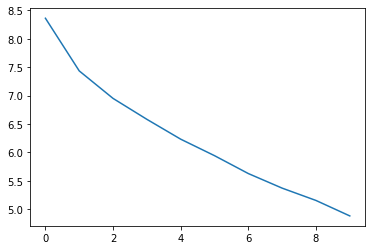

In [11]:
train_x=[]
train_y=[]
# convert the training history to a dataframe
history_df = pd.DataFrame(history.history)
# use Pandas native plot method
history_df['loss'].plot()

In [12]:
preds = model.predict(valid_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction = []
for i in range(valid_size):
    prediction.append(num_to_label(decoded[i]))
    
print(prediction[0:100])
print(train_valid_y[0:100])

['TRES', 'IS', 'SNIING', 'TO', 'GO', 'INTO', 'IN', 'FILM', 'AND', 'SONGS', 'PROECTON', 'NOOT', 'I', 'FAL', 'I', 'SCOME', 'OL', 'A', 'SEEW', 'AT', 'THE', 'BL', 'BHE', 'BALD', 'NOE', 'WE', 'SMALLY', 'SEGEND', 'TO', 'PART', 'GSGRUGT', 'SIS', 'GA', 'GEENT', 'IN', 'SOS', 'STHOUGOHT', 'SBPNNG', 'FRM', 'CSCEN', 'SO', 'ON', 'CENTRET', 'BETOON', 'SOONS', 'SFLT', 'SWND', 'HOY', 'SCONRL', 'FRM', 'SBEITOR', 'BEE', 'IT', 'RALNY', 'IS', 'SANG', 'BY', 'BRIATEL', 'MTHRGORS', 'IN', 'HIS', 'WNAT', 'OIER', 'SAN', 'BT', 'THIE', 'QPOUTEORS', 'SHUBET', 'SBONT', 'THE', 'BEM', 'MNAR', 'IF', 'MHANED', 'STPT', 'STERED', 'CNT', 'BLHT', 'BAVE', 'BY', 'SERGR', 'TOS', 'IS', 'IS', 'BHLNY', 'SOLE', 'GN', 'SIE', 'PLAS', 'TE', 'GEITNS', 'MTOR', 'AT', 'IA', 'SWANG', 'WHIOT', 'BONLY', 'MOERS', 'SUND', 'IA']
['TURNER', 'IS', 'AIMING', 'TO', 'GO', 'INTO', 'T', 'FILM', 'AND', 'STAGE', 'PRODUCTION', 'WORK', 'I', 'FEEL', 'I', 'DONE', 'ALL', 'I', 'CAN', 'AT', 'THE', 'B', 'HE', 'TOLD', 'ME', 'WE', 'MUTUALLY', 'AGREED', 'TO', 'P

In [13]:
#y_true = valid.loc[0:valid_size, 'IDENTITY']
y_true=valid_y
correct_char = 0
total_char = 0
correct = 0

for i in range(valid_size):
    pr = prediction[i]
    tr = train_valid_y[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))

Correct characters predicted : 29.99%
Correct words predicted      : 25.40%


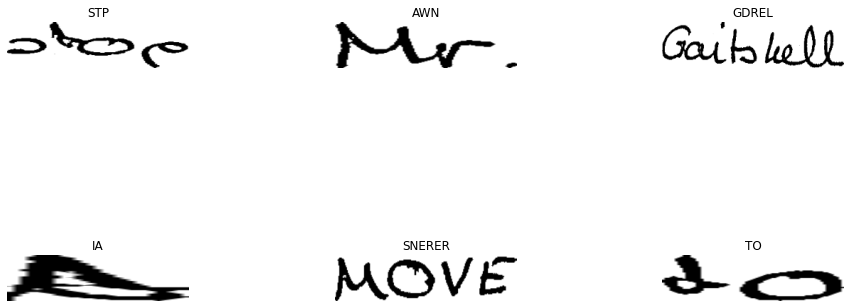

In [14]:
test = pd.read_csv('/kaggle/input/handwriting-recognition/written_name_test_v2.csv')
#test = pd.read_csv('/kaggle/input/rochattaname/names.csv')

plt.figure(figsize=(15, 10))
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    #img_dir = '/kaggle/input/handwriting-recognition/test_v2/test/'+test.loc[i, 'FILENAME']
    #img_dir = '/kaggle/input/train-data/images/'+test.loc[i, 'ID']
    img_dir = samples[i].filePath
    
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    bw= cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11, 10)
    bw=cv2.resize(bw,(256,64))
    kernal = np.ones((2,1), 'uint8')
    bw = cv2.morphologyEx(bw, cv2.MORPH_DILATE, kernal,iterations=1)#MORPH_DILATE
    plt.imshow(bw, cmap='gray')
    
    #image = image/255.
    pred = model.predict(bw.reshape(-1, 256,64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.8, hspace=-1.3)

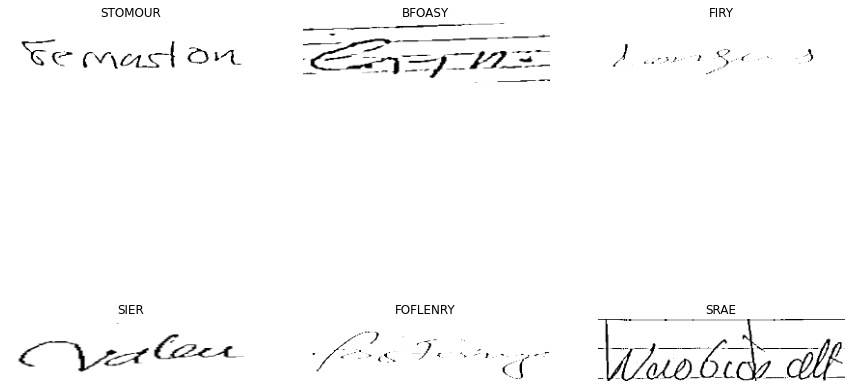

In [15]:
valid_x=[]
test = pd.read_csv('/kaggle/input/traindata/try.csv')

plt.figure(figsize=(15, 10))
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '/kaggle/input/train-data/images/'+str(i+1)+'.jpg'
    #img_dir = '/kaggle/input/train-data/images/1.jpg'
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    bw= cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11, 10)
    bw=cv2.resize(bw,(256,64))
    kernal = np.ones((2,1), 'uint8')
    bw = cv2.morphologyEx(bw, cv2.MORPH_DILATE, kernal,iterations=1)#MORPH_DILATE
    
    plt.imshow(bw, cmap='gray')
    
    #image = image/255.
    pred = model.predict(bw.reshape(1,256,64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=0.2)


In [16]:

test_train_size=60
test_train_x = []
test_train_y=[]
test_train=[]

test = pd.read_csv('/kaggle/input/traindata/try.csv')

li=test['ID']
li.to_list()


for i in range(test_train_size):
    xx=li[i]
    if (bool(re.match('^[a-zA-Z0-9]*$',xx))==True) and containsNumber(xx)==False :
        test_train.append(xx.upper())
        img_dir = '/kaggle/input/train-data/images/'+str(i+1)+'.jpg'
        image = cv2.imread(img_dir,cv2.IMREAD_GRAYSCALE)

        bw= cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11, 10)
        bw=cv2.resize(bw,(256,64))

        #end of local thresholding
        kernal = np.ones((2,1), 'uint8')
        bw = cv2.morphologyEx(bw, cv2.MORPH_DILATE, kernal,iterations=1)#MORPH_DILATE

        #image=image/255.0
        test_train_x.append(bw)
    else :
        test_train_size=test_train_size-1

#print(train)
test_train_x = np.array(test_train_x).reshape(-1,256,64, 1)


########### train
test_train_y = np.ones([test_train_size, max_str_len]) * -1
test_train_label_len = np.zeros([test_train_size, 1])
test_train_input_len = np.ones([test_train_size, 1]) * (num_of_timestamps-2)
test_train_output = np.zeros([test_train_size])

for j in range(test_train_size):
    test_train_label_len[j] = len(test_train[j])
    
    test_train_y[j, 0:len(test_train[j])]= label_to_num(test_train[j])  

test_train_y = np.array(test_train_y)


with tf.device('/device:GPU:0'):
    history=model_final.fit(x=[test_train_x,test_train_y,test_train_input_len,test_train_label_len], y=test_train_output,
                            epochs=6, batch_size=1)

Epoch 1/6
49/49 [==============================] - 3s 20ms/step - loss: 30.0402
Epoch 2/6
49/49 [==============================] - 1s 16ms/step - loss: 24.3457
Epoch 3/6
49/49 [==============================] - 1s 16ms/step - loss: 22.7780
Epoch 4/6
49/49 [==============================] - 1s 16ms/step - loss: 21.2484
Epoch 5/6
49/49 [==============================] - 1s 16ms/step - loss: 20.1576
Epoch 6/6
49/49 [==============================] - 1s 16ms/step - loss: 19.2103


In [17]:
test = pd.read_csv('/kaggle/input/traindata/try.csv')
our_data=[]
for i in range(60):
    img_dir = '/kaggle/input/train-data/images/'+str(i+1)+'.jpg'
    #img_dir = '/kaggle/input/train-data/images/1.jpg'
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    bw= cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11, 10)
    bw=cv2.resize(bw,(256,64))
    kernal = np.ones((2,1), 'uint8')
    bw = cv2.morphologyEx(bw, cv2.MORPH_DILATE, kernal,iterations=1)#MORPH_DILATE
    
    
    #image = image/255.
    pred = model.predict(bw.reshape(1, 256,64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    our_data.append(num_to_label(decoded[0]))
    
print(our_data)
li=test['ID']
li.to_list()
print(li[0:60])

['AMAIE', 'MO', '', 'RI', 'A', 'MMRINE', 'MSN', 'MEE', 'AOA', 'MIE', 'AIE', 'INE', 'AE', 'MN', 'ARO', 'A', 'A', 'A', 'A', 'A', 'AOAON', '', '', 'RAN', 'RON', 'RAE', 'RAIE', 'AOAOE', 'AOL', 'OE', '', 'A', 'A', 'A', 'A', 'SIN', 'AE', 'AID', 'AOION', 'AOL', 'OAIE', 'AE', 'RAIE', 'EOAOE', 'AI', 'RI', 'AO', 'AO', 'A', 'AOAON', 'OA', '', 'AI', 'N', 'AN', 'AN', 'AON', 'AON', 'OE', 'OAIN']
0                  femaston
1                      Gyno
2                    Longus
3                    Valens
4                fosfomycin
5               Neurorubine
6                     Mesna
7                    Keflex
8                 Bactroban
9                   Maximum
10                 Atropine
11                 Dicynone
12               folic acid
13                Tamoxifen
14                  Liberex
15                   clamid
16                    IVF-M
17                  Diclair
18                    oGyl 
19                      Tab
20                Ibuprofen
21                   Suprax

In [18]:
correct_char = 0
total_char = 0
correct = 0
test = pd.read_csv('/kaggle/input/traindata/try.csv')
li=test['ID']
li.to_list()
li=li[0:60]
for i in range(60):
    pr = our_data[i]
    tr =li[i]
    tr=tr.upper()
    print(pr,'###',tr)
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/1))

AMAIE ### FEMASTON
MO ### GYNO
 ### LONGUS
RI ### VALENS
A ### FOSFOMYCIN
MMRINE ### NEURORUBINE
MSN ### MESNA
MEE ### KEFLEX
AOA ### BACTROBAN
MIE ### MAXIMUM
AIE ### ATROPINE
INE ### DICYNONE
AE ### FOLIC ACID
MN ### TAMOXIFEN
ARO ### LIBEREX
A ### CLAMID
A ### IVF-M
A ### DICLAIR
A ### OGYL 
A ### TAB
AOAON ### IBUPROFEN
 ### SUPRAX
 ### ZOMAX
RAN ### VENTOLIN
RON ### ATROVENT
RAE ### PREDINSOLONE
RAIE ### OMEPRAZOLE
AOAOE ### VESICARE
AOL ### PROPRANOLOL
OE ### VIT E
 ### CREAM
A ### LEVOTAB
A ### URISEPT
A ### CONTIFLO
A ### TANAKAN
SIN ### ASPIRIN
AE ### TRI B
AID ### KLACID
AOION ### AMYDRAMINE
AOL ### MUSCADOL
OAIE ### NORMAL SALINE
AE ### PANADOL
RAIE ### ROCEPHIN
EOAOE ### DEXAMETHASONE
AI ### FAMOTIDINE
RI ### CETRIZINE
AO ### CYCLOGYL
AO ### FAVIMOL
A ### MALSOL SACHETS
AOAON ### ALFACORT OINTMENT
OA ### DESLORATADINE
 ### LACTO BACILLUS SACHET
AI ### ANTINAL 
N ### AUGMENTIN
AN ### GALCTOGIL
AN ### GYNO - HYDRA
AON ### SYMBION
AON ### CIPRO
OE ### SOLUPRED
OAIN ### MUCOSOL

In [19]:
model.save('/kaggle/working/models/model1')

In [20]:
#final_model.save("/kaggle/working/models/model2.h5")